#Transfer tif to png (done in local, need to be updated in jupyter notebook)
import cv2
import os
import numpy as np

path = os.getcwd()
print(path)

imagesDirectory= os.path.join(path,"sr_data")  # tif image directory
distDirectory = os.path.dirname(imagesDirectory)
distDirectory = os.path.join(distDirectory, "sr_png")# save directory

for imageName in os.listdir(imagesDirectory):
    imagePath = os.path.join(imagesDirectory, imageName)
    image = cv2.imread(imagePath)# open tif image
    img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    distImagePath = os.path.join(distDirectory, imageName[:-4]+'.png')# save imgaes
    cv2.imwrite(distImagePath,img)# write imgaes

In [ ]:
#Traninig

In [3]:
import argparse
import os
import numpy as np
import math
import itertools
import sys


import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable

from models import *
from datasets import *

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)


epoch=0
n_epochs=5
#dataset_name="img_hr"
batch_size=5
lr=0.0002
b1=0.5
b2=0.999
decay_epoch=100
n_cpu=8
hr_height=512
hr_width=512
channels=1
sample_interval=1
checkpoint_interval=-1

cuda = torch.cuda.is_available()

hr_shape = (hr_height, hr_width)

# Initialize generator and discriminator
generator = GeneratorResNet(in_channels=channels, out_channels=channels)
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

dataloader = DataLoader(
    #ImageDataset("../../data/%s" % opt.dataset_name, hr_shape=hr_shape),
    ImageDataset("../../data/", hr_shape=hr_shape),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

# ----------
#  Training
# ----------

Dloss=[]
Gloss=[]

for epoch in range(epoch, n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
    #    gen_features = feature_extractor(gen_hr)
        gen_features = feature_extractor(torch.cat((gen_hr,gen_hr,gen_hr),1))
    #    real_features = feature_extractor(imgs_hr)
        real_features = feature_extractor(torch.cat((imgs_hr,imgs_hr,imgs_hr),1))
    #    loss_content = criterion_content(gen_features, real_features.detach())
        loss_content = criterion_content(gen_hr, imgs_hr.detach()) + criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]\n"
            % (epoch, n_epochs, i, len(dataloader), loss_D.item(), loss_G.item())
        )

        Dloss.append(loss_D.item())
        Gloss.append(loss_G.item())

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            imgs_hr = make_grid(imgs_hr, nrow=1,normalize=True)
            img_grid = torch.cat((imgs_lr, gen_hr, imgs_hr), -1)
            save_image(img_grid, "images/%d.png" % batches_done, normalize=False)
             #print("batch_done:%d\n" %batches_done)           
    
    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" % epoch)


[Epoch 0/5] [Batch 0/20] [D loss: 0.818990] [G loss: 1.314640]
[Epoch 0/5] [Batch 1/20] [D loss: 3.853190] [G loss: 1.092241]
[Epoch 0/5] [Batch 2/20] [D loss: 1.028151] [G loss: 0.695332]
[Epoch 0/5] [Batch 3/20] [D loss: 0.697150] [G loss: 0.533893]
[Epoch 0/5] [Batch 4/20] [D loss: 0.978887] [G loss: 0.277106]
[Epoch 0/5] [Batch 5/20] [D loss: 0.878988] [G loss: 0.193997]
[Epoch 0/5] [Batch 6/20] [D loss: 0.313796] [G loss: 0.149561]
[Epoch 0/5] [Batch 7/20] [D loss: 0.453501] [G loss: 0.114990]
[Epoch 0/5] [Batch 8/20] [D loss: 0.271717] [G loss: 0.104507]
[Epoch 0/5] [Batch 9/20] [D loss: 0.371839] [G loss: 0.111284]
[Epoch 0/5] [Batch 10/20] [D loss: 0.263987] [G loss: 0.099009]
[Epoch 0/5] [Batch 11/20] [D loss: 0.265552] [G loss: 0.115078]
[Epoch 0/5] [Batch 12/20] [D loss: 0.251511] [G loss: 0.100293]
[Epoch 0/5] [Batch 13/20] [D loss: 0.249173] [G loss: 0.088714]
[Epoch 0/5] [Batch 14/20] [D loss: 0.259187] [G loss: 0.168960]
[Epoch 0/5] [Batch 15/20] [D loss: 0.249251] [G lo

In [5]:
print(Dloss)
print(Gloss)

[0.818989634513855, 3.8531899452209473, 1.028151035308838, 0.6971498727798462, 0.9788865447044373, 0.8789883852005005, 0.313795804977417, 0.45350080728530884, 0.27171698212623596, 0.37183865904808044, 0.26398739218711853, 0.2655518651008606, 0.25151053071022034, 0.24917268753051758, 0.25918737053871155, 0.24925082921981812, 0.26486778259277344, 0.2502251863479614, 0.2446676343679428, 0.24300682544708252, 0.2343195676803589, 0.23157766461372375, 0.22668933868408203, 0.21806037425994873, 0.21569664776325226, 0.22181761264801025, 0.2146247923374176, 0.22567716240882874, 0.2141486406326294, 0.22706009447574615, 0.20447513461112976, 0.19841629266738892, 0.192751944065094, 0.191789448261261, 0.24599868059158325, 0.264067143201828, 0.2648639976978302, 0.21233335137367249, 0.21855008602142334, 0.1892910897731781, 0.17014026641845703, 0.2314930558204651, 0.2778896689414978, 0.24044637382030487, 0.30741703510284424, 0.26370611786842346, 0.22681942582130432, 0.17388200759887695, 0.130239069461822

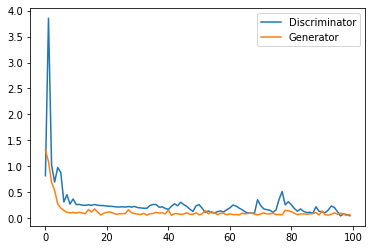

In [6]:
from matplotlib import pyplot
pyplot.plot(Dloss, label='Discriminator')
pyplot.plot(Gloss, label='Generator')
pyplot.legend()
pyplot.show()


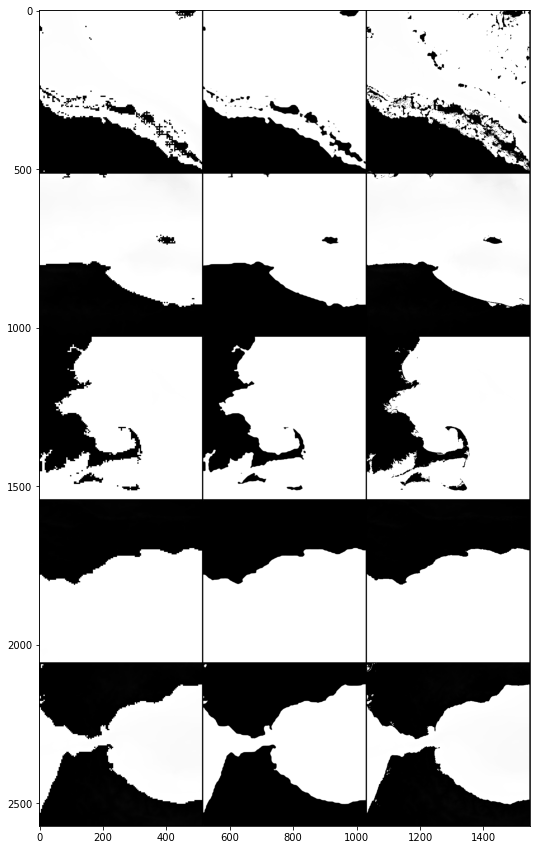

In [8]:
import matplotlib.pyplot as plt
fig, axes=plt.subplots(1,1,figsize=(9,15))
axes.imshow(img_grid.cpu().numpy()[0], cmap='gray') 